In [1]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import imageio
import pprint

import matplotlib.pyplot as plt

import run_nerf
import run_nerf_helpers

import scipy as sp


### Load trained network weights
Run `bash download_example_weights.sh` in the root directory if you need to download the Lego example weights

Args:
expname = lego_example
basedir = ./logs
datadir = ./data/nerf_synthetic/lego
dataset_type = blender

half_res = True
no_batching = True

N_samples = 64
N_importance = 64

use_viewdirs = True

white_bkgd = True

N_rand = 1024

MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
Not ndc!
Found ckpts ['./logs/lego_example/model_200000.npy']
Reloading from ./logs/lego_example/model_200000.npy


2022-03-18 10:03:26.156215: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-03-18 10:03:26.156247: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-18 10:03:26.156271: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (FOLKVANGR): /proc/driver/nvidia/version does not exist
2022-03-18 10:03:26.156535: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-03-18 10:03:26.181406: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600050000 Hz
2022-03-18 10:03:26.182085: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558c41a87bc0 initi

Resetting step to 200001
Reloading fine from ./logs/lego_example/model_fine_200000.npy
Render kwargs:
{'N_importance': 64,
 'N_samples': 64,
 'far': <tf.Tensor: id=927, shape=(), dtype=float32, numpy=6.0>,
 'lindisp': False,
 'ndc': False,
 'near': <tf.Tensor: id=926, shape=(), dtype=float32, numpy=2.0>,
 'network_fine': <tensorflow.python.keras.engine.training.Model object at 0x7f3f97788d90>,
 'network_fn': <tensorflow.python.keras.engine.training.Model object at 0x7f3fa1324650>,
 'network_query_fn': <function create_nerf.<locals>.network_query_fn at 0x7f3fa112f3b0>,
 'perturb': False,
 'raw_noise_std': 0.0,
 'use_viewdirs': True,
 'white_bkgd': True}
<function create_nerf.<locals>.network_query_fn at 0x7f3fa112f3b0>


2022-03-18 10:03:26.434183: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 161280000 exceeds 10% of system memory.
2022-03-18 10:03:26.485850: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 69120000 exceeds 10% of system memory.
2022-03-18 10:03:26.496255: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 230400000 exceeds 10% of system memory.
2022-03-18 10:03:26.877615: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 67108864 exceeds 10% of system memory.
2022-03-18 10:03:26.903757: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 67108864 exceeds 10% of system memory.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


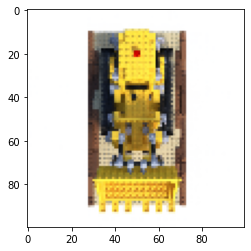

In [2]:
basedir = './logs'
# expname = 'robot_v2_test'
# itrname = 'model_990000.npy'
expname = 'lego_example'
itrname = 'model_200000.npy'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()
ft_str = '' 
ft_str = '--ft_path {}'.format(os.path.join(basedir, expname, itrname))
args = parser.parse_args('--config {} '.format(config) + ft_str)

# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(2., tf.float32),
    'far' : tf.cast(6., tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

net_fn = render_kwargs_test['network_query_fn']
print(net_fn)

# Render an overhead view to check model was loaded correctly
c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
c2w[2,-1] = 4.
H, W, focal = 800, 800, 1200.
down = 8
test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_test)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

### Query network on dense 3d grid of points

(257, 257, 86, 3)
(257, 257, 86, 4)


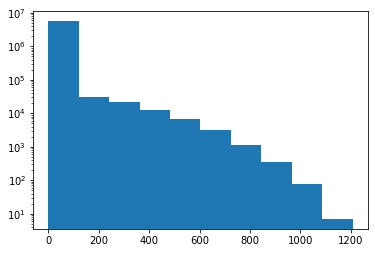

In [3]:
N = 256
tx = np.linspace(-1.2, 1.2, 257)
ty = np.linspace(-1.2, 1.2, 257)
tz = np.linspace( 0.2, 1.2, 86)

query_pts = np.stack(np.meshgrid(tx, ty, tz), -1).astype(np.float32)
print(query_pts.shape)
sh = query_pts.shape
flat = query_pts.reshape([-1,3])

def batchify(fn, chunk):
    if chunk is None:
        return fn
    def ret(inputs):
        return tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret
    
    
fn = lambda i0, i1 : net_fn(flat[i0:i1,None,:], viewdirs=np.zeros_like(flat[i0:i1]), network_fn=render_kwargs_test['network_fine'])
chunk = 1024*64
raw = np.concatenate([fn(i, i+chunk).numpy() for i in range(0, flat.shape[0], chunk)], 0)
raw = np.reshape(raw, list(sh[:-1]) + [-1])
sigma = np.maximum(raw[...,-1], 0.)

print(raw.shape)
plt.hist(np.maximum(0,sigma.ravel()), log=True)
plt.show()

In [4]:
# Tune Accordingly
thold = 600
step = 5

# Select the points that are within threshold
den_arr = np.reshape(sigma,(-1,1))
idx = np.where(den_arr>thold)[0]
X = flat[idx,:]

# Calculate mean of points
xb = np.mean(X[:,0])
yb = np.mean(X[:,1])
zb = np.mean(X[:,2])
Xb = np.array([xb,yb,zb])

# Determine the least-square fitted vector (principal component analysis)
PX = X-np.tile(Xb,(X.shape[0],1))
M = PX.T@PX
w, vl, vr = sp.linalg.eig(M, left=True)
e = vl[:,0,None]

# Generate waypoint
wp = np.hstack((Xb[:,None]-step*e,Xb[:,None]+step*e))

In [ ]:
# Plot waypoints through object as sanity check
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], c='b', marker='o')
ax.plot3D(wp[0,:], wp[1,:], wp[2,:], 'gray')

ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_zlim(-3,3)

ax.view_init(30, 120)
